In [ ]:
# ============================================================================
# IMPROVED NEURAL NETWORK
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


In [ ]:
# ============================================================================
# LOAD DATA FROM GOOGLE DRIVE
# ============================================================================
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/ML/midterm-regresi-dataset.csv'

df = pd.read_csv(file_path, header=None)
print(f"Dataset shape: {df.shape}")

Mounted at /content/drive
Dataset shape: (515345, 91)


In [ ]:
# ============================================================================
# PREPROCESSING - SIMPLIFIED & ROBUST
# ============================================================================
y = df.iloc[:, 0]  # Target
X = df.iloc[:, 1:]  # Features

print(f"\nTarget range: {y.min():.0f} - {y.max():.0f}")
print(f"Number of features: {X.shape[1]}")

# Handle missing values
X = X.fillna(X.median())
y = y.fillna(y.median())

# Remove extreme outliers (optional - conservative approach)
from scipy import stats
z_scores = np.abs(stats.zscore(X))
outlier_mask = (z_scores < 4).all(axis=1)  # Keep only non-extreme outliers
X = X[outlier_mask]
y = y[outlier_mask]

print(f"Data after outlier removal: {X.shape}")


Target range: 1922 - 2011
Number of features: 90
Data after outlier removal: (444968, 90)


In [ ]:
# ============================================================================
# TRAIN-TEST SPLIT
# ============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================================================
# FEATURE SCALING
# ============================================================================
# Gunakan StandardScaler untuk distribusi normal yang lebih baik
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Normalize target juga untuk membantu learning
y_mean = y_train.mean()
y_std = y_train.std()
y_train_scaled = (y_train - y_mean) / y_std
y_test_scaled = (y_test - y_mean) / y_std

print(f"Target normalized: mean={y_train_scaled.mean():.4f}, std={y_train_scaled.std():.4f}")

Target normalized: mean=0.0000, std=1.0000


In [ ]:
# ============================================================================
# SIMPLIFIED MODEL
# ============================================================================
def create_improved_model(input_dim):
    """
    Simplified architecture - lebih shallow, lebih efektif
    """
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),

        # Layer 1: Smaller, less aggressive
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Layer 2
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Layer 3
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),

        # Output
        layers.Dense(1)  # Linear activation
    ])

    # Optimizer dengan learning rate yang lebih kecil
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )

    return model

input_dim = X_train_scaled.shape[1]
model = create_improved_model(input_dim)

print("\n" + "="*80)
print("IMPROVED MODEL ARCHITECTURE")
print("="*80)
print(model.summary())



IMPROVED MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,785 (89.00 KB)

 Trainable params: 22,401 (87.50 KB)

 Non-trainable params: 384 (1.50 KB)

None


In [ ]:
# ============================================================================
# TRAINING WITH BETTER CALLBACKS
# ============================================================================
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,  # Lebih patient
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=1e-7,
    verbose=1
)

In [ ]:
# ============================================================================
# TRAIN MODEL
# ============================================================================
print("\n" + "="*80)
print("TRAINING MODEL")
print("="*80)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=64,  # Larger batch for stability
    callbacks=[early_stop, reduce_lr],
    verbose=1
)



TRAINING MODEL
Epoch 1/200
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.9914 - mae: 0.7335 - val_loss: 0.6527 - val_mae: 0.5710 - learning_rate: 5.0000e-04
Epoch 2/200
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - loss: 0.6765 - mae: 0.5794 - val_loss: 0.6319 - val_mae: 0.5536 - learning_rate: 5.0000e-04
Epoch 3/200
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.6582 - mae: 0.5691 - val_loss: 0.6245 - val_mae: 0.5486 - learning_rate: 5.0000e-04
Epoch 4/200
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.6410 - mae: 0.5594 - val_loss: 0.6176 - val_mae: 0.5448 - learning_rate: 5.0000e-04
Epoch 5/200
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.6339 - mae: 0.5562 - val_loss: 0.6137 - val_mae: 0.5455 - learning_rate: 5.0000e-04
Epoch 6/200
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.6309 - mae: 0.5555 - val_loss: 0.6130 - val_mae: 0.5485 - learning_rate: 5.0000e-04
Epoch 7/200
4450/4450 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.6231 - mae: 0.5520

In [ ]:
# ============================================================================
# PREDICTIONS & DENORMALIZE
# ============================================================================
y_train_pred_scaled = model.predict(X_train_scaled, verbose=0).flatten()
y_test_pred_scaled = model.predict(X_test_scaled, verbose=0).flatten()

# Denormalize predictions back to original scale
y_train_pred = (y_train_pred_scaled * y_std) + y_mean
y_test_pred = (y_test_pred_scaled * y_std) + y_mean

In [ ]:
# ============================================================================
# EVALUATION
# ============================================================================
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n" + "="*80)
print("MODEL EVALUATION RESULTS")
print("="*80)

print("\nTRAINING SET:")
print(f"  MSE  : {train_mse:.4f}")
print(f"  RMSE : {train_rmse:.4f}")
print(f"  MAE  : {train_mae:.4f}")
print(f"  R²   : {train_r2:.4f}")

print("\nTEST SET:")
print(f"  MSE  : {test_mse:.4f}")
print(f"  RMSE : {test_rmse:.4f}")
print(f"  MAE  : {test_mae:.4f}")
print(f"  R²   : {test_r2:.4f}")

if test_r2 > 0:
    print(f"\n✅ SUCCESS! R² is positive: {test_r2:.4f}")
else:
    print(f"\n⚠️ WARNING! R² is still negative: {test_r2:.4f}")
    print("Consider trying simpler models like Random Forest or Gradient Boosting")


MODEL EVALUATION RESULTS

TRAINING SET:
  MSE  : 65.9526
  RMSE : 8.1211
  MAE  : 5.6414
  R²   : 0.4481

TEST SET:
  MSE  : 71.5433
  RMSE : 8.4583
  MAE  : 5.8218
  R²   : 0.4038

✅ SUCCESS! R² is positive: 0.4038


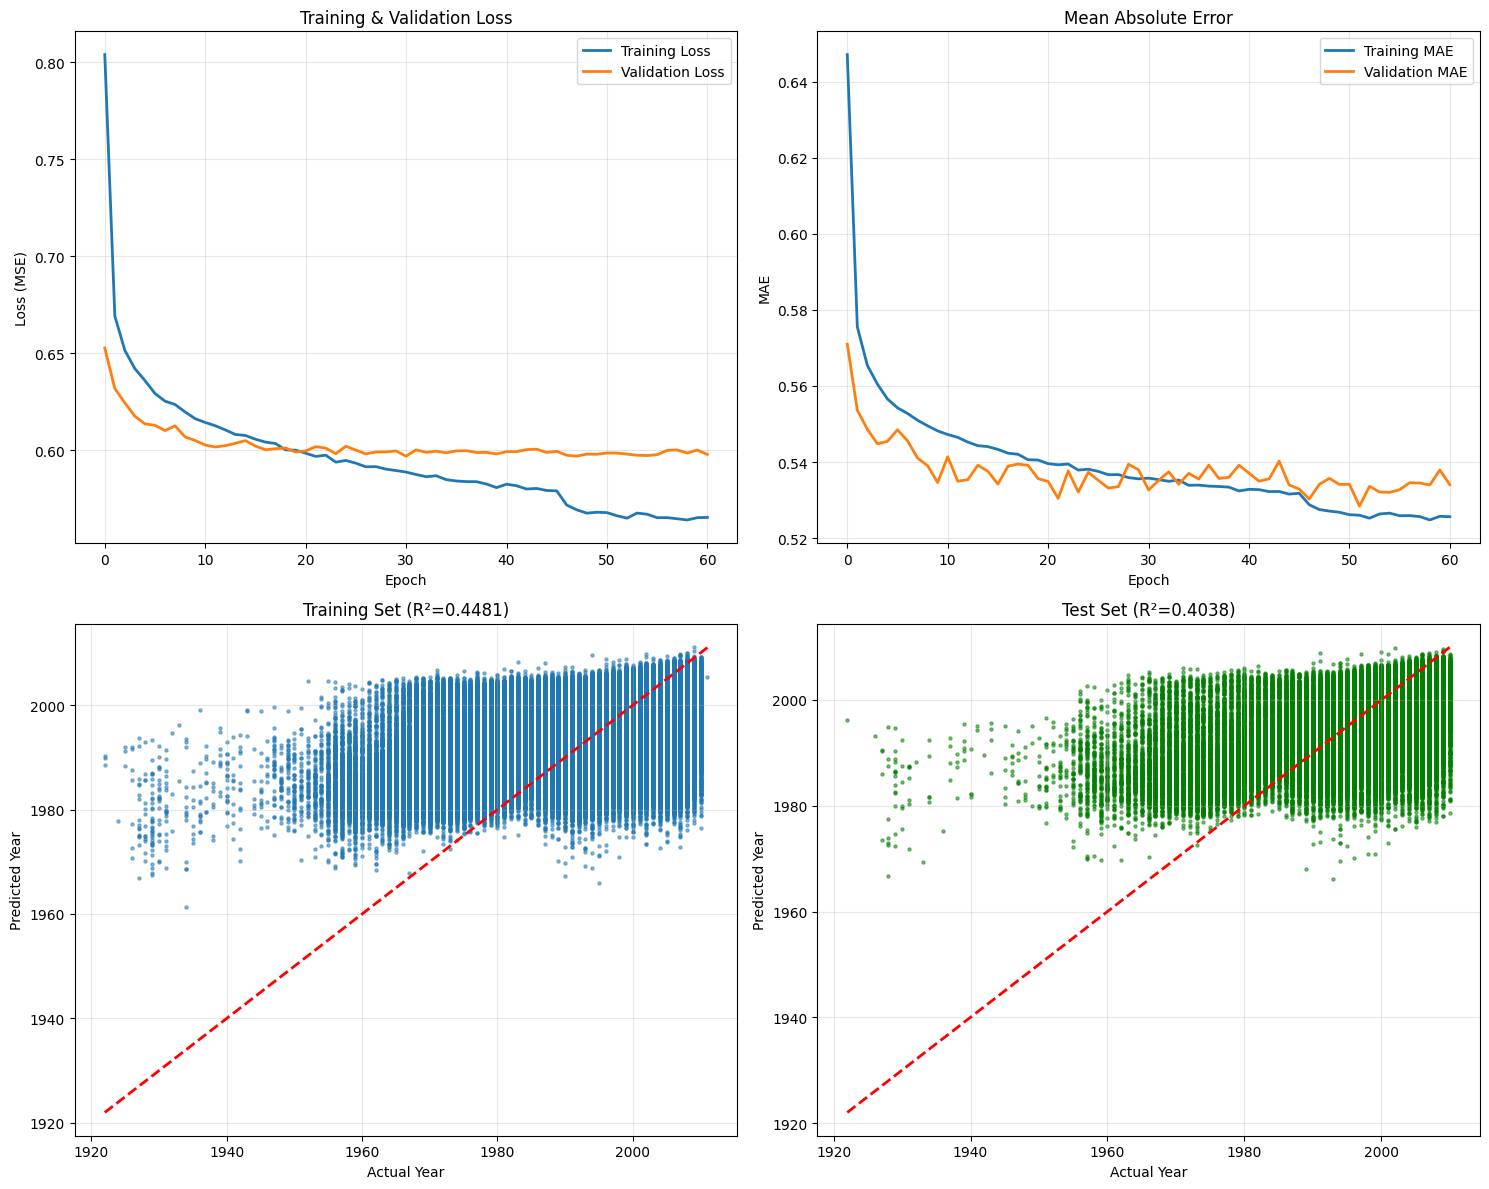

In [ ]:
# ============================================================================
# VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training history
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: MAE
axes[0, 1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[0, 1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('Mean Absolute Error')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Predictions vs Actual (Training)
axes[1, 0].scatter(y_train, y_train_pred, alpha=0.5, s=5)
axes[1, 0].plot([y_train.min(), y_train.max()],
                [y_train.min(), y_train.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Year')
axes[1, 0].set_ylabel('Predicted Year')
axes[1, 0].set_title(f'Training Set (R²={train_r2:.4f})')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Predictions vs Actual (Test)
axes[1, 1].scatter(y_test, y_test_pred, alpha=0.5, s=5, color='green')
axes[1, 1].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Year')
axes[1, 1].set_ylabel('Predicted Year')
axes[1, 1].set_title(f'Test Set (R²={test_r2:.4f})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# SAVE RESULTS
# ============================================================================
save_path = '/content/drive/MyDrive/ML/'

model.save(save_path + 'improved_music_model.h5')
print(f"\n✓ Model saved to: {save_path}improved_music_model.h5")

results_df = pd.DataFrame({
    'Actual_Year': y_test.values,
    'Predicted_Year': y_test_pred,
    'Error': np.abs(y_test.values - y_test_pred)
})
results_df.to_csv(save_path + 'improved_predictions.csv', index=False)
print(f"✓ Predictions saved")


✓ Model saved to: /content/drive/MyDrive/ML/improved_music_model.h5
✓ Predictions saved
